In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
import pickle

# 1. Cargar el dataset

In [2]:
df = pd.read_csv('heart_2022.csv', sep =',')
df

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,NaN,No,...,NaN,NaN,NaN,No,No,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
1,Alabama,Female,Excellent,0.0,0.0,NaN,No,6.0,NaN,No,...,1.60,68.04,26.57,No,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
2,Alabama,Female,Very good,2.0,3.0,Within past year (anytime less than 12 months ...,Yes,5.0,NaN,No,...,1.57,63.50,25.61,No,No,No,No,NaN,No,Yes
3,Alabama,Female,Excellent,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,7.0,NaN,No,...,1.65,63.50,23.30,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No
4,Alabama,Female,Fair,2.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,NaN,No,...,1.57,53.98,21.77,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445127,Virgin Islands,Female,Good,0.0,3.0,Within past 2 years (1 year but less than 2 ye...,Yes,6.0,None of them,No,...,1.65,69.85,25.63,NaN,Yes,No,No,"No, did not receive any tetanus shot in the pa...",No,Yes
445128,Virgin Islands,Female,Excellent,2.0,2.0,Within past year (anytime less than 12 months ...,Yes,7.0,None of them,No,...,1.70,83.01,28.66,No,Yes,Yes,No,"Yes, received tetanus shot but not sure what type",No,No
445129,Virgin Islands,Female,Poor,30.0,30.0,5 or more years ago,No,5.0,1 to 5,No,...,1.70,49.90,17.23,NaN,No,No,No,"No, did not receive any tetanus shot in the pa...",No,No
445130,Virgin Islands,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,5.0,None of them,Yes,...,1.83,108.86,32.55,No,Yes,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes


# 2. Exploraracion de los datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Data columns (total 40 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   State                      445132 non-null  object 
 1   Sex                        445132 non-null  object 
 2   GeneralHealth              443934 non-null  object 
 3   PhysicalHealthDays         434205 non-null  float64
 4   MentalHealthDays           436065 non-null  float64
 5   LastCheckupTime            436824 non-null  object 
 6   PhysicalActivities         444039 non-null  object 
 7   SleepHours                 439679 non-null  float64
 8   RemovedTeeth               433772 non-null  object 
 9   HadHeartAttack             442067 non-null  object 
 10  HadAngina                  440727 non-null  object 
 11  HadStroke                  443575 non-null  object 
 12  HadAsthma                  443359 non-null  object 
 13  HadSkinCancer              44

In [4]:
df.describe()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI
count,434205.000000,436065.000000,439679.000000,416480.000000,403054.000000,396326.000000
mean,4.347919,4.382649,7.022983,1.702691,83.074470,28.529842
std,8.688912,8.387475,1.502425,0.107177,21.448173,6.554889
min,0.000000,0.000000,1.000000,0.910000,22.680000,12.020000
25%,0.000000,0.000000,6.000000,1.630000,68.040000,24.130000
50%,0.000000,0.000000,7.000000,1.700000,80.740000,27.440000
75%,3.000000,5.000000,8.000000,1.780000,95.250000,31.750000
max,30.000000,30.000000,24.000000,2.410000,292.570000,99.640000


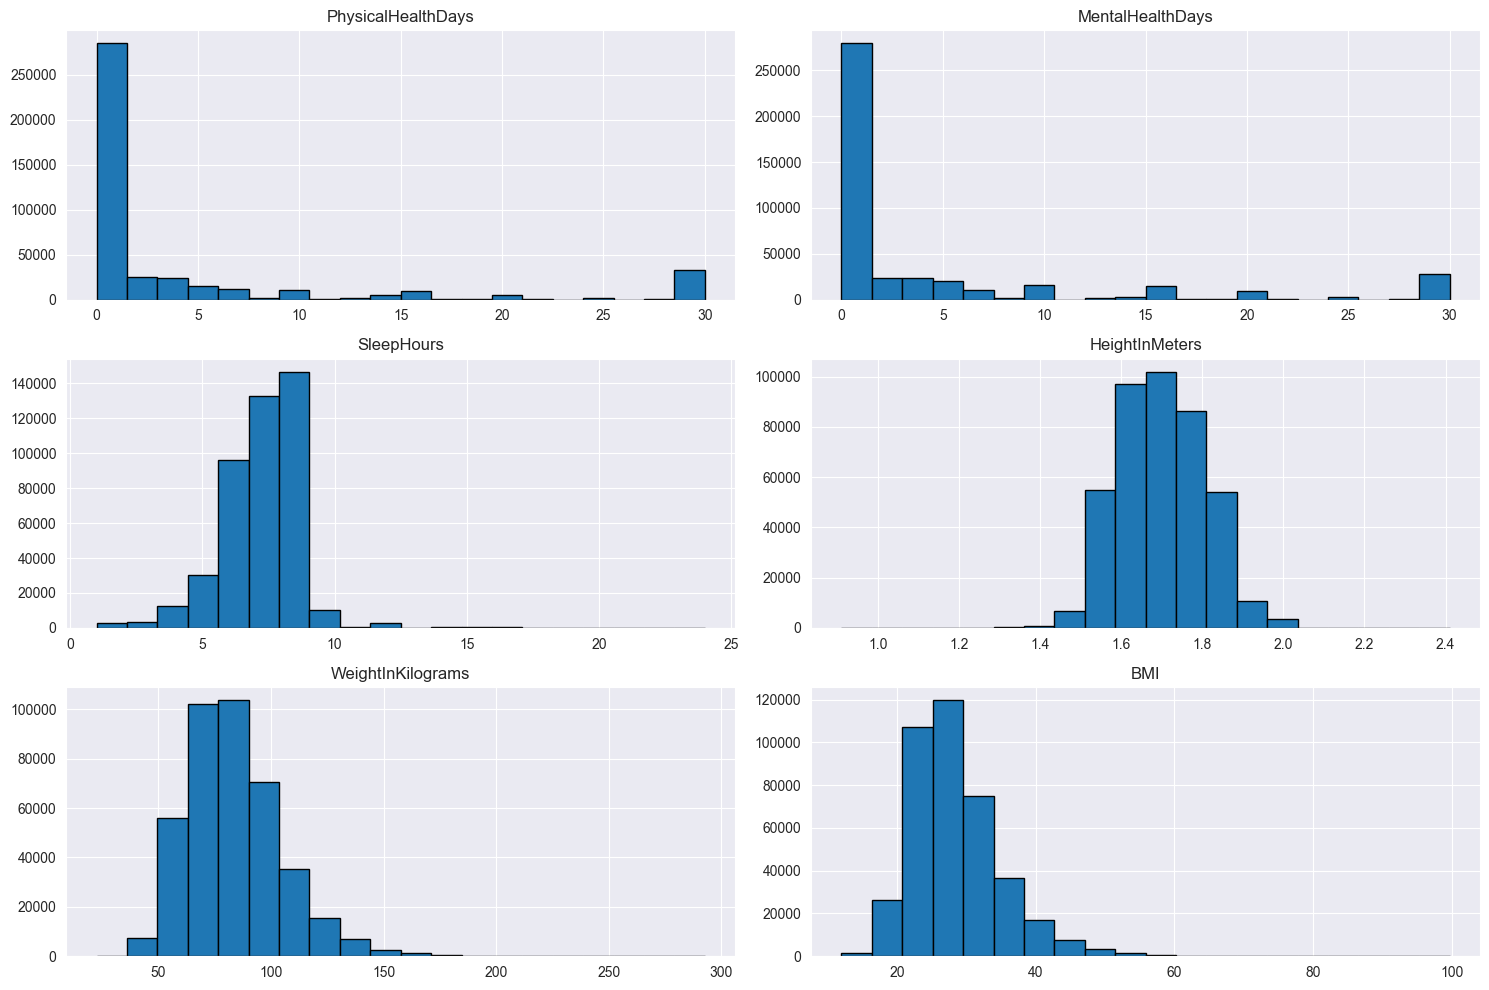

In [5]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Crear histogramas para todas las variables numéricas
df[numeric_columns].hist(figsize=(15, 10), bins=20, edgecolor='black')
plt.tight_layout()
plt.show()

# 3. Preparacion de los datos

In [6]:
# Verificar si hay valores nulos
df.isnull().sum()

State                            0
Sex                              0
GeneralHealth                 1198
PhysicalHealthDays           10927
MentalHealthDays              9067
LastCheckupTime               8308
PhysicalActivities            1093
SleepHours                    5453
RemovedTeeth                 11360
HadHeartAttack                3065
HadAngina                     4405
HadStroke                     1557
HadAsthma                     1773
HadSkinCancer                 3143
HadCOPD                       2219
HadDepressiveDisorder         2812
HadKidneyDisease              1926
HadArthritis                  2633
HadDiabetes                   1087
DeafOrHardOfHearing          20647
BlindOrVisionDifficulty      21564
DifficultyConcentrating      24240
DifficultyWalking            24012
DifficultyDressingBathing    23915
DifficultyErrands            25656
SmokerStatus                 35462
ECigaretteUsage              35660
ChestScan                    56046
RaceEthnicityCategor

In [7]:
# Llenar valores nulos solo en las columnas numéricas con la media
df[numeric_columns] = df[numeric_columns].apply(lambda x: x.fillna(x.mean()), axis=0)

# Eliminar filas con valores nulos en columnas categóricas
categorical_columns = df.select_dtypes(include=['object']).columns
df_cleaned = df.dropna(subset=categorical_columns)

# Verificar si quedan valores nulos en el dataset limpio
null_values_cleaned = df_cleaned.isnull().sum()

# Mostrar las primeras filas del nuevo dataset
df_cleaned.head()

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
342,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
343,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
345,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
346,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
347,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


In [8]:
df_cleaned.isnull().sum()

State                        0
Sex                          0
GeneralHealth                0
PhysicalHealthDays           0
MentalHealthDays             0
LastCheckupTime              0
PhysicalActivities           0
SleepHours                   0
RemovedTeeth                 0
HadHeartAttack               0
HadAngina                    0
HadStroke                    0
HadAsthma                    0
HadSkinCancer                0
HadCOPD                      0
HadDepressiveDisorder        0
HadKidneyDisease             0
HadArthritis                 0
HadDiabetes                  0
DeafOrHardOfHearing          0
BlindOrVisionDifficulty      0
DifficultyConcentrating      0
DifficultyWalking            0
DifficultyDressingBathing    0
DifficultyErrands            0
SmokerStatus                 0
ECigaretteUsage              0
ChestScan                    0
RaceEthnicityCategory        0
AgeCategory                  0
HeightInMeters               0
WeightInKilograms            0
BMI     

In [9]:
# Identificación de outliers utilizando el método del rango intercuartílico (IQR)
def detect_outliers_iqr(data, columns):
    outliers = {}
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = data[(data[col] < lower_bound) | (data[col] > upper_bound)][col]
    return outliers

# Detectar outliers en las columnas numéricas
outliers = detect_outliers_iqr(df_cleaned, numeric_columns)

# Resumen de outliers encontrados
outliers_summary = {col: len(outliers[col]) for col in outliers if not outliers[col].empty}
outliers_summary

{'PhysicalHealthDays': 34152,
 'MentalHealthDays': 35230,
 'SleepHours': 3867,
 'HeightInMeters': 917,
 'WeightInKilograms': 6401,
 'BMI': 9475}

In [10]:
numeric_vars = [
    'PhysicalHealthDays', 'MentalHealthDays', 'SleepHours',
    'HeightInMeters', 'WeightInKilograms', 'BMI'
]

# Calcular los límites IQR
limits = {}
for var in numeric_vars:
    Q1 = df_cleaned[var].quantile(0.25)
    Q3 = df_cleaned[var].quantile(0.75)
    IQR = Q3 - Q1
    Lower_Limit = Q1 - 1.5 * IQR
    Upper_Limit = Q3 + 1.5 * IQR
    limits[var] = {'Lower_Limit': Lower_Limit, 'Upper_Limit': Upper_Limit}

# Filtrar datos para eliminar outliers
df_no_outliers = df_cleaned.copy()
for var in numeric_vars:
    Lower_Limit = limits[var]['Lower_Limit']
    Upper_Limit = limits[var]['Upper_Limit']
    df_no_outliers = df_no_outliers[
        (df_no_outliers[var] >= Lower_Limit) & (df_no_outliers[var] <= Upper_Limit)
    ]

# Aplicar límites médicos
height_min = 1.2
height_max = 2.2
weight_min = 30
weight_max = 200
bmi_min = 15
bmi_max = 50

df_no_outliers = df_no_outliers[
    (df_no_outliers['HeightInMeters'] >= height_min) & (df_no_outliers['HeightInMeters'] <= height_max) &
    (df_no_outliers['WeightInKilograms'] >= weight_min) & (df_no_outliers['WeightInKilograms'] <= weight_max) &
    (df_no_outliers['BMI'] >= bmi_min) & (df_no_outliers['BMI'] <= bmi_max)
]

print(f"Número de registros antes de eliminar outliers: {df_cleaned.shape[0]}")
print(f"Número de registros después de eliminar outliers: {df_no_outliers.shape[0]}")

Número de registros antes de eliminar outliers: 267281
Número de registros después de eliminar outliers: 200196


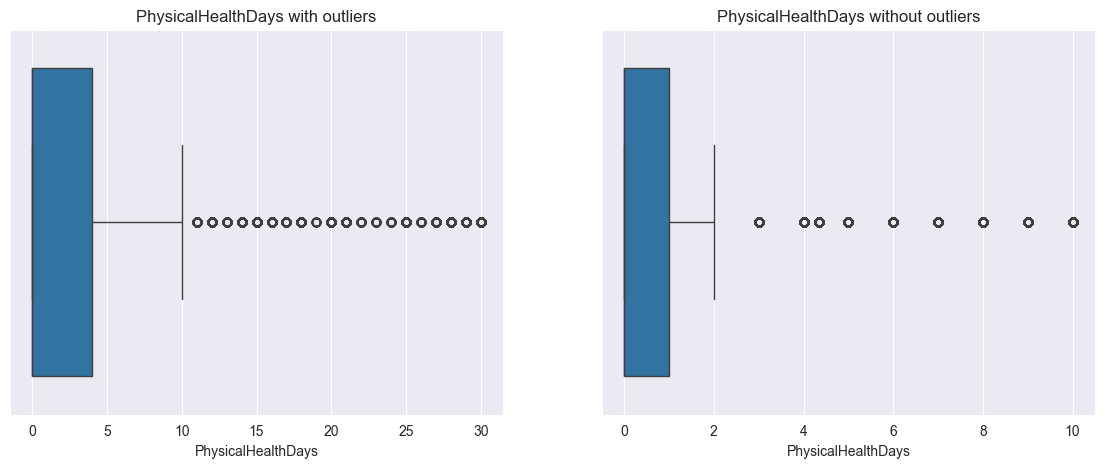

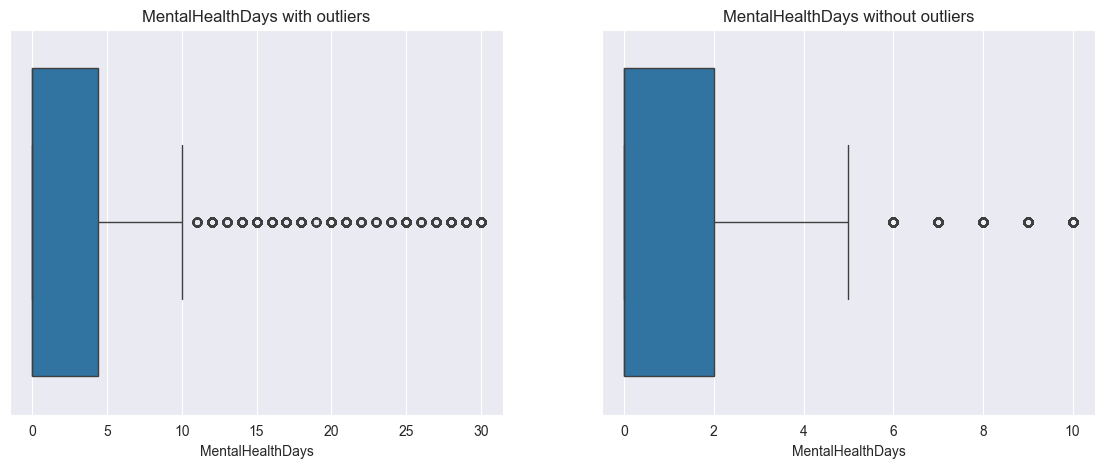

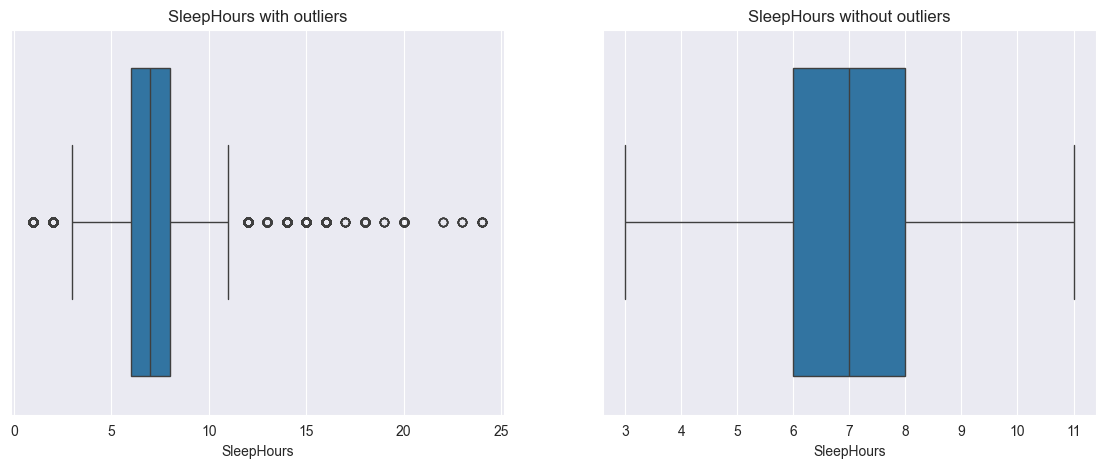

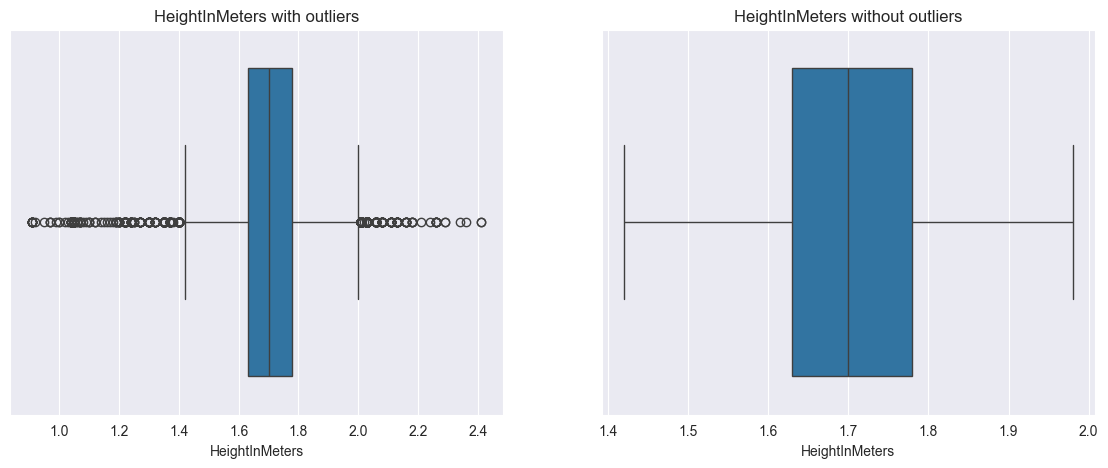

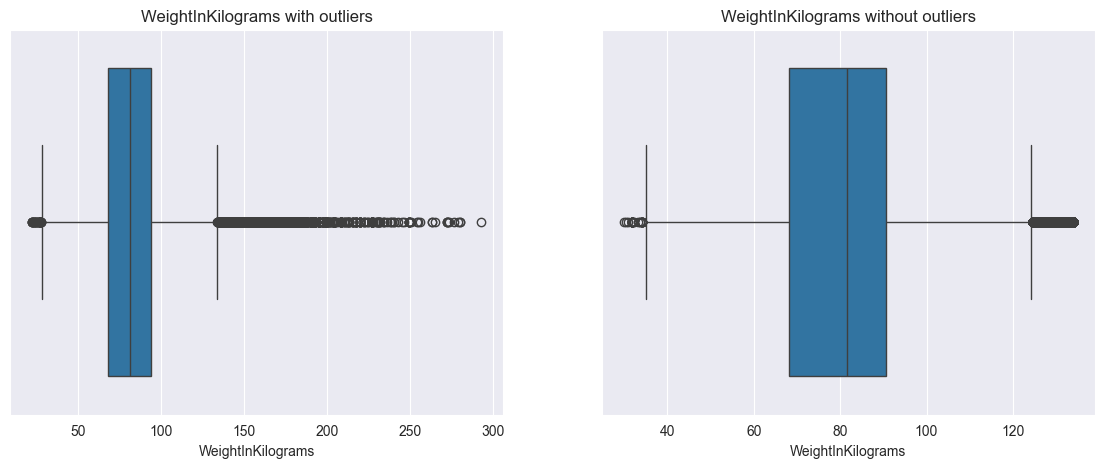

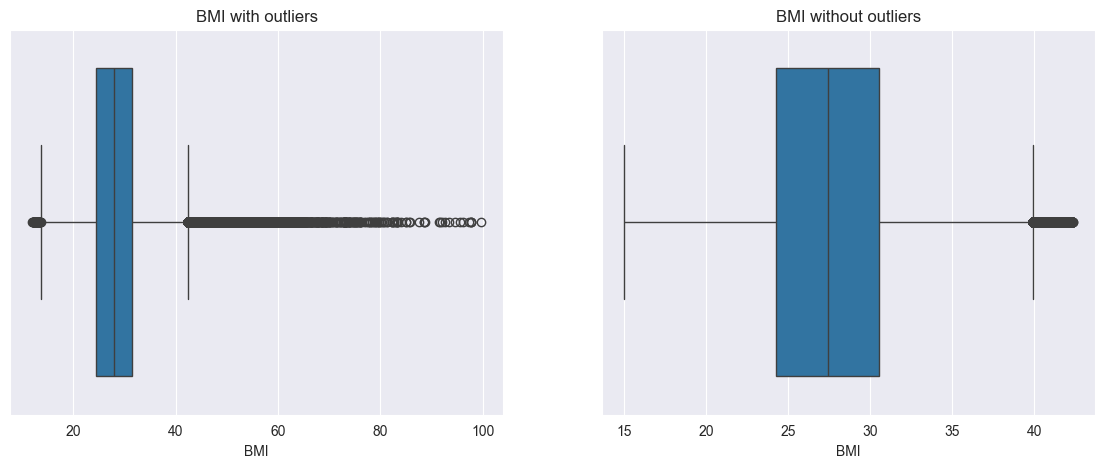

In [11]:
# Visualizar distribuciones
for var in numeric_vars:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.boxplot(data=df_cleaned, x=var, ax=axes[0])
    axes[0].set_title(f'{var} with outliers')
    
    sns.boxplot(data=df_no_outliers, x=var, ax=axes[1])
    axes[1].set_title(f'{var} without outliers')
    
    plt.show()

# Creacion de pipelines para la transformacion de los datos

In [12]:
# Identificar variables numéricas y categóricas
numerical_features = df_no_outliers.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df_no_outliers.select_dtypes(include=['object', 'category']).columns.tolist()

# Eliminar la variable objetivo de las listas
target_column = 'HadHeartAttack'
numerical_features = [col for col in numerical_features if col != target_column]
categorical_features = [col for col in categorical_features if col != target_column]

In [13]:
# Pipeline para variables numéricas
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para variables categóricas
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

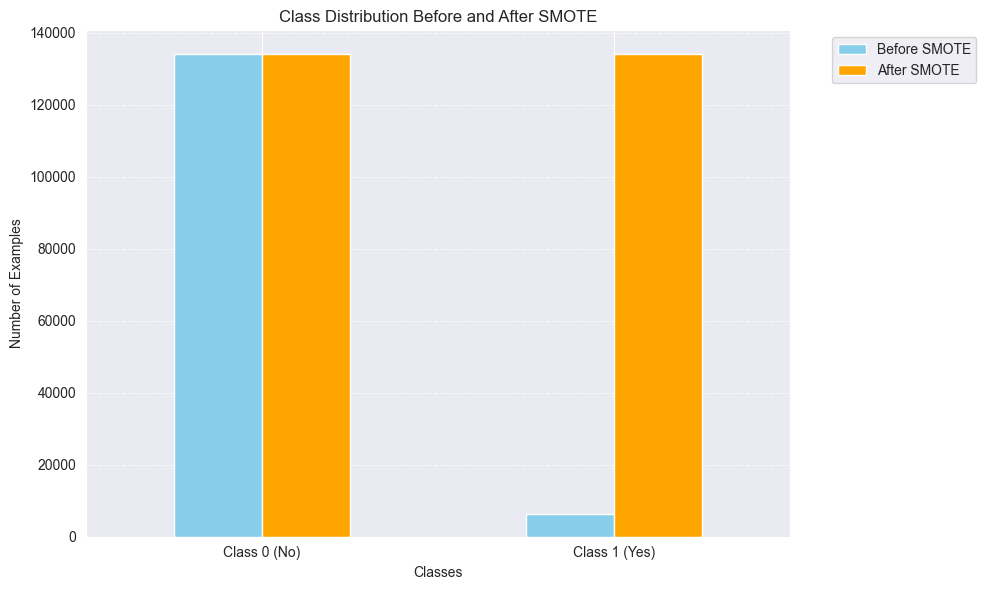

In [14]:
X = df_no_outliers.drop(target_column, axis=1)
y = df_no_outliers[target_column]

# Convertir la variable objetivo a numérica
y = y.map({'Yes': 1, 'No': 0})

# Dividir los datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Preprocesar los datos antes de aplicar SMOTE
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Aplicar SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_preprocessed, y_train)

# Obtener la distribución de clases antes y después de SMOTE
class_counts_before = y_train.value_counts()
class_counts_after = pd.Series(y_train_smote).value_counts()

# Crear un DataFrame para comparar
df_comparison = pd.DataFrame({
    'Antes de SMOTE': class_counts_before,
    'Después de SMOTE': class_counts_after
})

# Plotear la comparación
ax = df_comparison.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], rot=0)
plt.title('Class Distribution Before and After SMOTE')
plt.xlabel('Classes')
plt.ylabel('Number of Examples')
plt.xticks([0, 1], ['Class 0 (No)', 'Class 1 (Yes)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(['Before SMOTE', 'After SMOTE'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Entrenar modelos de Machine Learning

## Regresión Logística

In [15]:
# Crear el pipeline completo para la regresión logística
pipeline_logreg = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Entrenar el modelo
pipeline_logreg.fit(X_train, y_train)

# Realizar predicciones
y_pred_logreg = pipeline_logreg.predict(X_test)
y_pred_logreg_proba = pipeline_logreg.predict_proba(X_test)[:, 1]

print("Regresión Logística:")
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred_logreg))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_logreg_proba))

Regresión Logística:

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90     57407
           1       0.17      0.76      0.28      2652

    accuracy                           0.83     60059
   macro avg       0.58      0.80      0.59     60059
weighted avg       0.95      0.83      0.88     60059

AUC-ROC: 0.8837691802448611


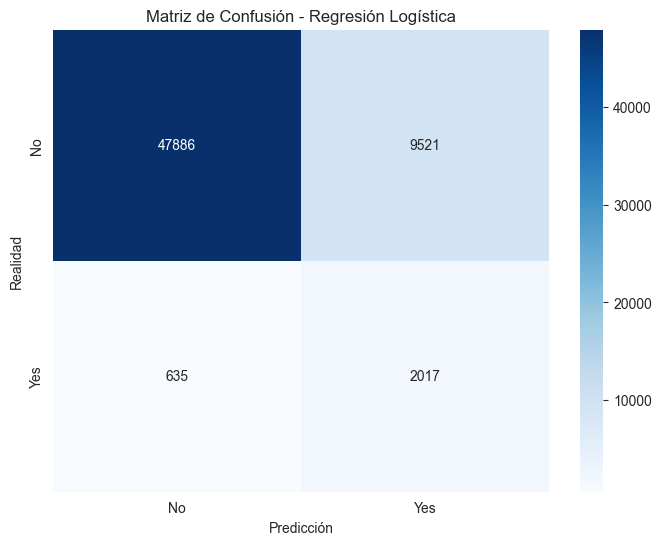

In [16]:
cm_logreg = confusion_matrix(y_test, y_pred_logreg)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Matriz de Confusión - Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

In [17]:
# Guardar el pipeline completo de Regresión Logística
with open('pipeline_logreg.pkl', 'wb') as file:
    pickle.dump(pipeline_logreg, file)

# Cargar el pipeline
with open('pipeline_logreg.pkl', 'rb') as file:
    loaded_pipeline_logreg = pickle.load(file)

# Verificar cargado
print(loaded_pipeline_logreg)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['PhysicalHealthDays',
                                                   'MentalHealthDays',
                                                   'SleepHours',
                                                   'HeightInMeters',
                                                   'WeightInKilograms',
                                                   'BMI']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                    

## Red Neuronal

In [18]:
# Aplicar el preprocesamiento al conjunto de entrenamiento y prueba
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convertir a arrays densos
X_train_smote_dense = X_train_smote.toarray()
X_test_dense = X_test_preprocessed.toarray()

# Redimensionar los datos para que tengan una dimensión temporal
X_train_rnn = X_train_smote_dense.reshape((X_train_smote_dense.shape[0], 1, X_train_smote_dense.shape[1]))
X_test_rnn = X_test_dense.reshape((X_test_dense.shape[0], 1, X_test_dense.shape[1]))

# Convertir las etiquetas a numpy arrays si es necesario
y_train_smote = np.array(y_train_smote)
y_test = np.array(y_test)

In [19]:
# Definir el modelo
model = Sequential()
model.add(SimpleRNN(units=50, input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2]), activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train_rnn, y_train_smote, epochs=20, batch_size=32, validation_data=(X_test_rnn, y_test))

Epoch 1/20


C:\Users\sebas\DataspellProjects\ComplexNetworks\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8372/8372 ━━━━━━━━━━━━━━━━━━━━ 7s 721us/step - accuracy: 0.8153 - loss: 0.4048 - val_accuracy: 0.8363 - val_loss: 0.3780
Epoch 2/20
8372/8372 ━━━━━━━━━━━━━━━━━━━━ 6s 659us/step - accuracy: 0.8740 - loss: 0.3031 - val_accuracy: 0.8804 - val_loss: 0.2988
Epoch 3/20
8372/8372 ━━━━━━━━━━━━━━━━━━━━ 6s 665us/step - accuracy: 0.9012 - loss: 0.2500 - val_accuracy: 0.8846 - val_loss: 0.2876
Epoch 4/20
8372/8372 ━━━━━━━━━━━━━━━━━━━━ 6s 656us/step - accuracy: 0.9121 - loss: 0.2252 - val_accuracy: 0.9155 - val_loss: 0.2391
Epoch 5/20
8372/8372 ━━━━━━━━━━━━━━━━━━━━ 6s 667us/step - accuracy: 0.9193 - loss: 0.2080 - val_accuracy: 0.8596 - val_loss: 0.3501
Epoch 6/20
8372/8372 ━━━━━━━━━━━━━━━━━━━━ 6s 675us/step - accuracy: 0.9233 - loss: 0.1968 - val_accuracy: 0.9011 - val_loss: 0.2688
Epoch 7/20
8372/8372 ━━━━━━━━━━━━━━━━━━━━ 6s 709us/step - accuracy: 0.9269 - loss: 0.1872 - val_accuracy: 0.9000 - val_loss: 0.2769
Epoch 8/20
8372/8372 ━━━━━━━━━━━━━━━━━━━━ 6s 754us/step - accuracy: 0.9301 - loss: 0.18

In [20]:
# Evaluar el modelo en el conjunto de prueba
loss, accuracy = model.evaluate(X_test_rnn, y_test)
print("\nRed Neuronal Recurrente:")
print("Pérdida:", loss)
print("Exactitud:", accuracy)

1877/1877 ━━━━━━━━━━━━━━━━━━━━ 1s 425us/step - accuracy: 0.9184 - loss: 0.2487

Red Neuronal Recurrente:
Pérdida: 0.24544794857501984
Exactitud: 0.9196456670761108


In [21]:
# Realizar predicciones
y_pred_proba = model.predict(X_test_rnn).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# Mostrar métricas de rendimiento
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

1877/1877 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96     57407
           1       0.26      0.44      0.32      2652

    accuracy                           0.92     60059
   macro avg       0.62      0.69      0.64     60059
weighted avg       0.94      0.92      0.93     60059

AUC-ROC: 0.8165621589917048


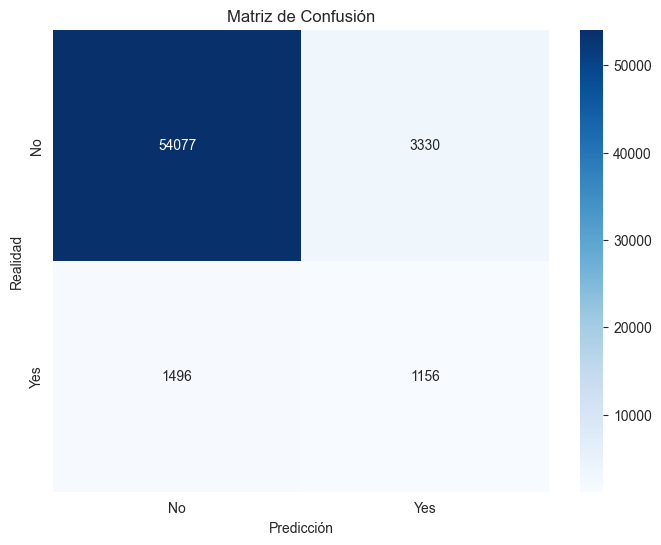

In [22]:
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

In [23]:
# Guardar la red neuronal recurrente
model.save('rnn_model.keras')

# Cargar la red neuronal recurrente
rnn_model = load_model('rnn_model.keras')
rnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │        10,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,905 (120.73 KB)

 Trainable params: 10,301 (40.24 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,604 (80.49 KB)

In [28]:
# Save the preprocessor
with open('preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)